In [2]:
# Python imports
from __future__ import division, print_function, unicode_literals
import numpy as np # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
import math
import time
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)
from sklearn import datasets, metrics # data and evaluation utils
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from matplotlib.colors import colorConverter, ListedColormap # some plotting functions
import itertools
import collections
import csv

In [4]:
# load the data from scikit-learn.
digits = fetch_openml('mnist_784')


# Load the targets.
# Note that the targets are stored as digits, these need to be 
#  converted to one-hot-encoding for the output sofmax layer.
n = digits.target.shape[0]
T = np.zeros((n,10))
T[np.arange(len(T)), digits.target.astype(int)] += 1
# Divide the data into a train and test set.
X_train, X_test, T_train, T_test = train_test_split(
    digits.data, T, test_size=0.4)
# Divide the test set into a validation set and final test set.
X_validation, X_test, T_validation, T_test = train_test_split(
    X_test, T_test, test_size=0.5)
print(">>>>>>DATASET FEATURE SPACE<<<<<<")
print(">>>TRAIN<<<")
print(X_train.shape)
print(T_train.shape)
print(">>>VALIDATION<<<")
print(X_validation.shape)
print(T_validation.shape)
print(">>>TEST<<<")                              
print(X_test.shape)
print(T_test.shape)

#with open("T_TEST_DATA.csv","w") as my_csv:
#    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator='},\n{')
#    csvWriter.writerows(T_test)

#with open("X_TEST_DATA.csv","w") as my_csv:
#    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator='},\n{')
#    csvWriter.writerows(X_test)

>>>>>>DATASET FEATURE SPACE<<<<<<
>>>TRAIN<<<
(42000, 784)
(42000, 10)
>>>VALIDATION<<<
(14000, 784)
(14000, 10)
>>>TEST<<<
(14000, 784)
(14000, 10)


In [5]:
# Define the non-linear functions used
def logistic(z): 
    return 1 / (1 + np.exp(-z))

def logistic_deriv(y):  # Derivative of logistic function
    return np.multiply(y, (1 - y))

def ReLU(x):
    return np.maximum(x, 0, x)

def ReLU_Der(out):
    out[out<=0] = 0
    out[out>0] = 1
    return out

def softmax(z): 
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

In [6]:
class Layer(object):
    """Base class for the different layers.
    Defines base methods and documentation of methods."""
    
    def get_params_iter(self):
        """Return an iterator over the parameters (if any).
        The iterator has the same order as get_params_grad.
        The elements returned by the iterator are editable in-place."""
        return []
    
    def get_params_grad(self, X, output_grad):
        """Return a list of gradients over the parameters.
        The list has the same order as the get_params_iter iterator.
        X is the input.
        output_grad is the gradient at the output of this layer.
        """
        return []
    
    def get_output(self, X):
        """Perform the forward step linear transformation.
        X is the input."""
        pass
    
    def get_input_grad(self, Y, output_grad=None, T=None):
        """Return the gradient at the inputs of this layer.
        Y is the pre-computed output of this layer (not needed in this case).
        output_grad is the gradient at the output of this layer 
         (gradient at input of next layer).
        Output layer uses targets T to compute the gradient based on the 
         output error instead of output_grad"""
        pass
    
class LinearLayer(Layer):
    """The linear layer performs a linear transformation to its input."""
    
    def __init__(self, n_in, n_out):
        """Initialize hidden layer parameters.
        n_in is the number of input variables.
        n_out is the number of output variables."""
        self.W = np.random.randn(n_in, n_out) * 0.1
        self.b = np.zeros(n_out)
        
    def get_params_iter(self):
        """Return an iterator over the parameters."""
        return itertools.chain(np.nditer(self.W, op_flags=['readwrite']),
                               np.nditer(self.b, op_flags=['readwrite']))
    
    def get_params_array(self):
        """Return arrays of the parameters."""
        return np.array(self.W), np.array(self.b)
    
    def get_output(self, X):
        """Perform the forward step linear transformation."""
        return X.dot(self.W) + self.b
        
    def get_params_grad(self, X, output_grad):
        """Return a list of gradients over the parameters."""
        JW = X.T.dot(output_grad)
        Jb = np.sum(output_grad, axis=0)
        return [g for g in itertools.chain(np.nditer(JW), np.nditer(Jb))]
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        return output_grad.dot(self.W.T)
    
class LogisticLayer(Layer):
    """The logistic layer applies the logistic function to its inputs."""
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return logistic(X)
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        return np.multiply(logistic_deriv(Y), output_grad)
    
class ReLULayer(Layer):
    """The ReLU layer applies the Rectified Linear Units function to its inputs."""
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return ReLU(X)
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        return np.multiply(ReLU_Der(Y), output_grad)
    
class SoftmaxOutputLayer(Layer):
    """The softmax output layer computes the classification propabilities at the output."""
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return softmax(X)
    
    def get_input_grad(self, Y, T):
        """Return the gradient at the inputs of this layer."""
        return (Y - T) / Y.shape[0]
    
    def get_cost(self, Y, T):
        """Return the cost at the output of this output layer."""
        return - np.multiply(T, np.log(Y)).sum() / Y.shape[0]

In [7]:
# Define a sample model to be trained on the data
hidden_neurons_1 = 500  # Number of neurons in the first hidden-layer
hidden_neurons_2 = 150  # Number of neurons in the second hidden-layer
print("HIDDEN LAYER 1 NEURONS: {}".format(hidden_neurons_1))
print("HIDDEN LAYER 2 NEURONS: {}".format(hidden_neurons_2))
# Create the model
layers_SG = [] # Define a list of layers
#layers_ReLU = []
layers_ReLU_SG = []
# Add first hidden layer
layers_SG.append(LinearLayer(X_train.shape[1], hidden_neurons_1))
layers_SG.append(LogisticLayer())

#DEACTIVATED UNTIL THE DYING ReLU PROBLEM IS FIXED
#layers_ReLU.append(LinearLayer(X_train.shape[1], hidden_neurons_1))
#layers_ReLU.append(ReLULayer())

layers_ReLU_SG.append(LinearLayer(X_train.shape[1], hidden_neurons_1))
layers_ReLU_SG.append(ReLULayer())
# Add second hidden layer
layers_SG.append(LinearLayer(hidden_neurons_1, hidden_neurons_2))
layers_SG.append(LogisticLayer())

#DEACTIVATED UNTIL THE DYING ReLU PROBLEM IS FIXED
#layers_ReLU.append(LinearLayer(hidden_neurons_1, hidden_neurons_2))
#layers_ReLU.append(ReLULayer())

layers_ReLU_SG.append(LinearLayer(hidden_neurons_1, hidden_neurons_2))
layers_ReLU_SG.append(LogisticLayer())
# Add output layer
layers_SG.append(LinearLayer(hidden_neurons_2, T_train.shape[1]))
layers_SG.append(SoftmaxOutputLayer())

#DEACTIVATED UNTIL THE DYING ReLU PROBLEM IS FIXED
#layers_ReLU.append(LinearLayer(hidden_neurons_2, T_train.shape[1]))
#layers_ReLU.append(SoftmaxOutputLayer())

layers_ReLU_SG.append(LinearLayer(hidden_neurons_2, T_train.shape[1]))
layers_ReLU_SG.append(SoftmaxOutputLayer())

HIDDEN LAYER 1 NEURONS: 500
HIDDEN LAYER 2 NEURONS: 150


In [8]:
# Define the forward propagation step as a method.
def forward_step(input_samples, layers):
    """
    Compute and return the forward activation of each layer in layers.
    Input:
        input_samples: A matrix of input samples (each row is an input vector)
        layers: A list of Layers
    Output:
        A list of activations where the activation at each index i+1 corresponds to
        the activation of layer i in layers. activations[0] contains the input samples.  
    """
    activations = [input_samples] # List of layer activations
    # Compute the forward activations for each layer starting from the first
    X = input_samples
    for layer in layers:
        Y = layer.get_output(X)  # Get the output of the current layer
        activations.append(Y)  # Store the output for future processing
        X = activations[-1]  # Set the current input as the activations of the previous layer
    return activations  # Return the activations of each layer

# Define the backward propagation step as a method
def backward_step(activations, targets, layers):
    """
    Perform the backpropagation step over all the layers and return the parameter gradients.
    Input:
        activations: A list of forward step activations where the activation at 
            each index i+1 corresponds to the activation of layer i in layers. 
            activations[0] contains the input samples. 
        targets: The output targets of the output layer.
        layers: A list of Layers corresponding that generated the outputs in activations.
    Output:
        A list of parameter gradients where the gradients at each index corresponds to
        the parameters gradients of the layer at the same index in layers. 
    """
    param_grads = collections.deque()  # List of parameter gradients for each layer
    output_grad = None  # The error gradient at the output of the current layer
    # Propagate the error backwards through all the layers.
    #  Use reversed to iterate backwards over the list of layers.
    for layer in reversed(layers):   
        Y = activations.pop()  # Get the activations of the last layer on the stack
        # Compute the error at the output layer.
        # The output layer error is calculated different then hidden layer error.
        if output_grad is None:
            input_grad = layer.get_input_grad(Y, targets)
        else:  # output_grad is not None (layer is not output layer)
            input_grad = layer.get_input_grad(Y, output_grad)
        # Get the input of this layer (activations of the previous layer)
        X = activations[-1]
        # Compute the layer parameter gradients used to update the parameters
        grads = layer.get_params_grad(X, output_grad)
        param_grads.appendleft(grads)
        # Compute gradient at output of previous layer (input of current layer):
        output_grad = input_grad
    return list(param_grads)  # Return the parameter gradients

In [9]:
# Perform gradient checking
nb_samples_gradientcheck = 10 # Test the gradients on a subset of the data
X_temp = X_train[0:nb_samples_gradientcheck,:]
T_temp = T_train[0:nb_samples_gradientcheck,:]
# Get the parameter gradients with backpropagation
activations_SG = forward_step(X_temp, layers_SG)
param_grads_SG = backward_step(activations_SG, T_temp, layers_SG)

#activations_ReLU = forward_step(X_temp, layers_ReLU)
#param_grads_ReLU = backward_step(activations_ReLU, T_temp, layers_ReLU)

#activations_ReLU_SG = forward_step(X_temp, layers_ReLU_SG)
#param_grads_ReLU_SG = backward_step(activations_ReLU_SG, T_temp, layers_ReLU_SG)

# Set the small change to compute the numerical gradient
eps = 0.0001
# Compute the numerical gradients of the parameters in all layers.
for idx in range(len(layers_SG)):
    layer_SG = layers_SG[idx]
#    layer_ReLU = layers_ReLU[idx]
#    layer_ReLU_SG = layers_ReLU_SG[idx]
    
    layer_backprop_grads_SG = param_grads_SG[idx]
#    layer_backprop_grads_ReLU = param_grads_ReLU[idx]
#    layer_backprop_grads_ReLU_SG = param_grads_ReLU_SG[idx]
    # Compute the numerical gradient for each parameter in the SG layer
    for p_idx, param in enumerate(layer_SG.get_params_iter()):
        grad_backprop = layer_backprop_grads_SG[p_idx]
        # + eps
        param += eps
        plus_cost = layers_SG[-1].get_cost(forward_step(X_temp, layers_SG)[-1], T_temp)
        # - eps
        param -= 2 * eps
        min_cost = layers_SG[-1].get_cost(forward_step(X_temp, layers_SG)[-1], T_temp)
        # reset param value
        param += eps
        # calculate numerical gradient
        grad_num = (plus_cost - min_cost)/(2*eps)
        # Raise error if the numerical grade is not close to the backprop gradient
        if not math.isclose(grad_num, grad_backprop, rel_tol=1e-04, abs_tol=1e-05):
            raise ValueError('SG NN: Numerical gradient of {:.6f} is not close to the backpropagation gradient of {:.6f}!'.format(float(grad_num), float(grad_backprop)))
#DEACTIVATED UNTIL THE DYING ReLU PROBLEM IS FIXED
    # Compute the numerical gradient for each parameter in the ReLU layer
#    for p_idx, param in enumerate(layer_ReLU.get_params_iter()):
#        grad_backprop = layer_backprop_grads_ReLU[p_idx]
#        # + eps
#        param += eps
#        plus_cost = layers_ReLU[-1].get_cost(forward_step(X_temp, layers_ReLU)[-1], T_temp)
#        # - eps
#        param -= 2 * eps
#        min_cost = layers_ReLU[-1].get_cost(forward_step(X_temp, layers_ReLU)[-1], T_temp)
#        # reset param value
#        param += eps
#        # calculate numerical gradient
#        grad_num = (plus_cost - min_cost)/(2*eps)
#        # Raise error if the numerical grade is not close to the backprop gradient
#        if not math.isclose(grad_num, grad_backprop, rel_tol=1e-04, abs_tol=1e-05):
#            raise ValueError('ReLU NN: Numerical gradient of {:.6f} is not close to the backpropagation gradient of {:.6f}!'.format(float(grad_num), float(grad_backprop)))
    # Compute the numerical gradient for each parameter in the ReLU_SG layer    
#    for p_idx, param in enumerate(layer_ReLU_SG.get_params_iter()):
#        grad_backprop = layer_backprop_grads_ReLU_SG[p_idx]
#        # + eps
#        param += eps
#        plus_cost = layers_ReLU_SG[-1].get_cost(forward_step(X_temp, layers_ReLU_SG)[-1], T_temp)
#        # - eps
#        param -= 2 * eps
#        min_cost = layers_ReLU_SG[-1].get_cost(forward_step(X_temp, layers_ReLU_SG)[-1], T_temp)
#        # reset param value
#        param += eps
#        # calculate numerical gradient
#        grad_num = (plus_cost - min_cost)/(2*eps)
#        # Raise error if the numerical grade is not close to the backprop gradient
#        if not math.isclose(grad_num, grad_backprop, rel_tol=1e-03, abs_tol=1e-04):
#            raise ValueError('ReLU_SG NN: Numerical gradient of {:.6f} is not close to the backpropagation gradient of {:.6f}!'.format(float(grad_num), float(grad_backprop)))
print('No gradient errors found')

No gradient errors found


In [10]:
# Create the minibatches
batch_size = 500  # Approximately 500 samples per batch
nb_of_batches = X_train.shape[0] / batch_size  # Number of batches
# Create batches (X,Y) from the training set
XT_batches = list(zip(
    np.array_split(X_train, nb_of_batches, axis=0),  # X samples
    np.array_split(T_train, nb_of_batches, axis=0)))  # Y targets
# Define a method to update the parameters
def update_params(layers, param_grads, learning_rate):
    """
    Function to update the parameters of the given layers with the given gradients
    by gradient descent with the given learning rate.
    """
    for layer, layer_backprop_grads in zip(layers, param_grads):
        for param, grad in zip(layer.get_params_iter(), layer_backprop_grads):
            # The parameter returned by the iterator point to the memory space of
            #  the original layer and can thus be modified inplace.
            param -= learning_rate * grad  # Update each parameter
def get_accuracy(output_activation, T):
    true_pred = 0
    for idx, pred in enumerate(output_activation):
        pred_digit = np.argmax(pred)
        label_digit = np.argmax(T[idx])
        if pred_digit == label_digit:
            true_pred += 1
    accuracy = (true_pred/len(T))*100
    return accuracy

def get_certainty(output_activation):
    certainty = []
    for idx, pred in enumerate(output_activation):
        certainty.append((np.amax(pred))*100)
    av_certainty = sum(certainty)/float(len(certainty))
    return av_certainty, certainty

In [11]:
# Perform backpropagation
max_nb_of_iterations = 300  # Train for a maximum of 300 iterations (Epochs)
learning_rate = 0.1  # Gradient descent learning rate

def train_network(layers):
    # initalize some lists to store the cost for future analysis        
    minibatch_costs = []
    training_costs = []
    train_accuracy = []
    train_certainty = []
    validation_costs = []
    val_accuracy = []
    val_certainty = []
    # Train for the maximum number of iterations
    start_time = time.time()
    for iteration in range(max_nb_of_iterations):
        print("Starting Epoch: {}".format(iteration+1))
        for X, T in XT_batches:  # For each minibatch sub-iteration
            activations = forward_step(X, layers)  # Get the activations
            minibatch_cost = layers[-1].get_cost(activations[-1], T)  # Get cost
            minibatch_costs.append(minibatch_cost)
            param_grads = backward_step(activations, T, layers)  # Get the gradients
            update_params(layers, param_grads, learning_rate)  # Update the parameters
        # Get full training cost for future analysis (plots)
        activations = forward_step(X_train, layers)
        train_accuracy.append(get_accuracy(activations[-1], T_train))
        train_certainty.append(get_certainty(activations[-1])[0])
        train_cost = layers[-1].get_cost(activations[-1], T_train)
        training_costs.append(train_cost)
        # Get full validation cost
        activations = forward_step(X_validation, layers)
        val_accuracy.append(get_accuracy(activations[-1], T_validation))
        val_certainty.append(get_certainty(activations[-1])[0])
        validation_cost = layers[-1].get_cost(activations[-1], T_validation)
        validation_costs.append(validation_cost)
        if len(validation_costs) > 3:
            # Stop training if the cost on the validation set doesn't decrease
            #  for 3 iterations
            if validation_costs[-1] >= validation_costs[-2] >= validation_costs[-3]:
                print("CONVERGENCE ACHIEVED!")
                break
    end_time = time.time()
    t_time = end_time - start_time
    nb_of_iterations = iteration + 1  # The number of iterations that have been executed
    return layers, nb_of_iterations, minibatch_costs, training_costs, validation_costs, train_accuracy, train_certainty, val_accuracy, val_certainty, t_time

def plot_result(nb_of_iterations, minibatch_costs, training_costs, validation_costs, train_accuracy, train_certainty, val_accuracy, val_certainty, t_time):    
    # Plot the minibatch, full training set, and validation costs
    minibatch_x_inds = np.linspace(0, nb_of_iterations, num=nb_of_iterations*nb_of_batches)
    iteration_x_inds = np.linspace(1, nb_of_iterations, num=nb_of_iterations)
    # Plot the cost over the iterations
    plt.plot(minibatch_x_inds, minibatch_costs, 'k-', linewidth=0.5, label='cost minibatches')
    plt.plot(iteration_x_inds, training_costs, 'r-', linewidth=2, label='cost full training set')
    plt.plot(iteration_x_inds, validation_costs, 'b-', linewidth=3, label='cost validation set')
    # Add labels to the plot
    plt.xlabel('iteration')
    plt.ylabel('$\\xi$', fontsize=15)
    plt.title('Decrease of cost over backprop epochs')
    plt.legend()
    x1,x2,y1,y2 = plt.axis()
    plt.axis((0,nb_of_iterations,0,1.5))
    plt.grid()
    plt.show()
    #Plot accuracy
    plt.plot(iteration_x_inds, train_accuracy, 'r-', linewidth=2, label='accuracy full training set')
    plt.plot(iteration_x_inds, val_accuracy, 'b-', linewidth=3, label='accuracy validation set')
    # Add labels to the plot
    plt.xlabel('iteration')
    plt.ylabel('Accuracy', fontsize=15)
    plt.title('Increase of accuracy over backprop epochs')
    plt.legend()
    x1,x2,y1,y2 = plt.axis()
    plt.axis((0,nb_of_iterations,0,100))
    plt.grid()
    plt.show()
    #Plot certainty
    plt.plot(iteration_x_inds, train_certainty, 'r-', linewidth=2, label='certainty full training set')
    plt.plot(iteration_x_inds, val_certainty, 'b-', linewidth=3, label='certainty validation set')
    # Add labels to the plot
    plt.xlabel('iteration')
    plt.ylabel('Certainty', fontsize=15)
    plt.title('Increase of certainty over backprop epochs')
    plt.legend()
    x1,x2,y1,y2 = plt.axis()
    plt.axis((0,nb_of_iterations,0,100))
    plt.grid()
    plt.show()
    #Print time for training
    m, s = divmod(t_time, 60)
    h, m = divmod(m, 60)
    print("NUMBER OF TRAINING EPOCHS: {}".format(nb_of_iterations))
    print("OVERALL TIME FOR TRAINING & VALIDATION: {}h:{}m:{}s".format(h,m,s))
    print("LAST THREE VALIDATION COSTS: {} {} {}".format(validation_costs[-3], validation_costs[-2], validation_costs[-1]))

In [ ]:
#layers_SG, nb_of_iterations_SG, minibatch_costs_SG, training_costs_SG, validation_costs_SG, train_accuracy_SG, train_certainty_SG, val_accuracy_SG, val_certainty_SG, time_SG = train_network(layers_SG)
layers_ReLU_SG, nb_of_iterations_ReLU_SG, minibatch_costs_ReLU_SG, training_costs_ReLU_SG, validation_costs_ReLU_SG, train_accuracy_ReLU_SG, train_certainty_ReLU_SG, val_accuracy_ReLU_SG, val_certainty_ReLU_SG, time_ReLU_SG = train_network(layers_ReLU_SG)

#plot_result(nb_of_iterations_SG, minibatch_costs_SG, training_costs_SG, validation_costs_SG, train_accuracy_SG, train_certainty_SG, val_accuracy_SG, val_certainty_SG, time_SG)
plot_result(nb_of_iterations_ReLU_SG, minibatch_costs_ReLU_SG, training_costs_ReLU_SG, validation_costs_ReLU_SG, train_accuracy_ReLU_SG, train_certainty_ReLU_SG, val_accuracy_ReLU_SG, val_certainty_ReLU_SG, time_ReLU_SG)


Starting Epoch: 1
Starting Epoch: 2
Starting Epoch: 3
Starting Epoch: 4
Starting Epoch: 5
Starting Epoch: 6
Starting Epoch: 7
Starting Epoch: 8
Starting Epoch: 9
Starting Epoch: 10
Starting Epoch: 11
Starting Epoch: 12
Starting Epoch: 13
Starting Epoch: 14
Starting Epoch: 15
Starting Epoch: 16
Starting Epoch: 17
Starting Epoch: 18
Starting Epoch: 19
Starting Epoch: 20
Starting Epoch: 21
Starting Epoch: 22
Starting Epoch: 23
Starting Epoch: 24
Starting Epoch: 25
Starting Epoch: 26
Starting Epoch: 27
Starting Epoch: 28
Starting Epoch: 29
Starting Epoch: 30
Starting Epoch: 31
Starting Epoch: 32
Starting Epoch: 33
Starting Epoch: 34


In [10]:
def test_network(layers, T_test):
    # Get results of test data
    y_true = np.argmax(T_test, axis=1)  # Get the target outputs
    activations = forward_step(X_test, layers)  # Get activation of test samples
    y_pred = np.argmax(activations[-1], axis=1)  # Get the predictions made by the network
    test_accuracy = metrics.accuracy_score(y_true, y_pred)  # Test set accuracy
    print('The accuracy on the test set is {:.2f}'.format(test_accuracy))
    test_accuracy = get_accuracy(activations[-1], T_test)
    av_test_certainty, test_certainty = get_certainty(activations[-1])
    print("TEST ACCURACY: {}%".format(test_accuracy))
    print("AVERAGE TEST CERTAINTY: {}%".format(av_test_certainty))
    return y_true, y_pred, test_accuracy, av_test_certainty, test_certainty

def plot_confusion_table(y_true, y_pred):
    # Show confusion table
    conf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=None)  # Get confustion matrix
    # Plot the confusion table
    class_names = ['${:d}$'.format(x) for x in range(0, 10)]  # Digit class names
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Show class labels on each axis
    ax.xaxis.tick_top()
    major_ticks = range(0,10)
    minor_ticks = [x + 0.5 for x in range(0, 10)]
    ax.xaxis.set_ticks(major_ticks, minor=False)
    ax.yaxis.set_ticks(major_ticks, minor=False)
    ax.xaxis.set_ticks(minor_ticks, minor=True)
    ax.yaxis.set_ticks(minor_ticks, minor=True)
    ax.xaxis.set_ticklabels(class_names, minor=False, fontsize=15)
    ax.yaxis.set_ticklabels(class_names, minor=False, fontsize=15)
    # Set plot labels
    ax.yaxis.set_label_position("right")
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    fig.suptitle('Confusion table', y=1.03, fontsize=15)
    # Show a grid to seperate digits
    ax.grid(b=True, which=u'minor')
    # Color each grid cell according to the number classes predicted
    ax.imshow(conf_matrix, interpolation='nearest', cmap='binary')
    # Show the number of samples in each cell
    for x in range(conf_matrix.shape[0]):
        for y in range(conf_matrix.shape[1]):
            color = 'w' if x == y else 'k'
            ax.text(x, y, conf_matrix[y,x], ha="center", va="center", color=color)       
    plt.show()

def SHOW_IMAGES(INPUT_FEATURES, LABELS, P_LABELS, CERTAINTY):
    
    print("Would You Like to See Image Prediction?")
    USER_I = input()
    if (USER_I == 'Yes' or USER_I == 'Y' or USER_I == 'y'):
        ROW = 4
        COLUMN = 5
        n_per_frame = ROW * COLUMN
        n_frames = len(INPUT_FEATURES)/(n_per_frame)
        for frame in range(int(n_frames)):
            for i in range(ROW * COLUMN):
                image = INPUT_FEATURES[frame*n_per_frame+i].reshape(28, 28)   # not necessary to reshape if ndim is set to 2
                plt.subplot(ROW, COLUMN, i+1)          # subplot with size (width 3, height 5)
                plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
                plt.title('P [{}]({}%)'.format(P_LABELS[frame*n_per_frame+i], int(CERTAINTY[frame*n_per_frame+i])))
                #plt.set_xlabel('L({})'.format(LABELS[frame*n_per_frame+i]))
                plt.axis('off')  # do not show axis value
            plt.tight_layout()   # automatic padding between subplots
            #pad=0, w_pad=0, h_pad=2
            #plt.savefig('images/mnist_plot.png')
            plt.show()
            if frame == (n_frames - 1):
                print('Showed You All!')
                break
            print("Would You Like to See Some More?")
            USER_I = input()
            if (USER_I == 'No' or USER_I == 'N' or USER_I == 'n'):
                print("Enough is Enough I Guess!")
                break
    elif (USER_I == 'No' or USER_I == 'N' or USER_I == 'n'):
        print("Well Your Loss!")
    else: print("Did not get that, try y/n")
    return 1

D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


The accuracy on the test set is 0.97
TEST ACCURACY: 96.75%
AVERAGE TEST CERTAINTY: 97.01830792766184%


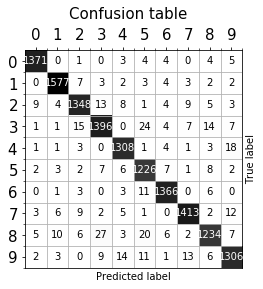

Would You Like to See Image Prediction?
y


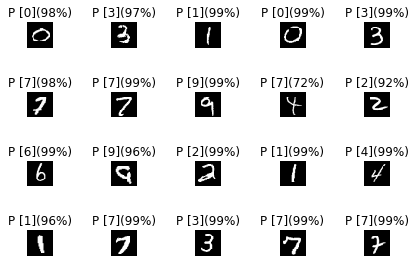

Would You Like to See Some More?
n
Enough is Enough I Guess!


1

In [11]:
#labels_output, pred_output_SG, test_accuracy, test_certainty, certainty_vec = test_network(layers_SG, T_test)
labels_output, pred_output_ReLU_SG, test_accuracy, test_certainty, certainty_vec = test_network(layers_ReLU_SG, T_test)

#plot_confusion_table(labels_output, pred_output_SG)
plot_confusion_table(labels_output, pred_output_ReLU_SG)

SHOW_IMAGES(X_test, labels_output, pred_output_ReLU_SG, certainty_vec)

In [2]:
#Write the model into files
w1, b1 = layers_ReLU_SG[0].get_params_array()
w2, b2 = layers_ReLU_SG[2].get_params_array()
w3, b3 = layers_ReLU_SG[4].get_params_array()

with open("ReLU_SG_HL_1_W.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator='},\n{')
    csvWriter.writerows(w1)
    
with open("ReLU_SG_HL_1_b.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator='},\n{')
    csvWriter.writerow(b1)

with open("ReLU_SG_HL_2_W.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator='},\n{')
    csvWriter.writerows(w2)
    
with open("ReLU_SG_HL_2_b.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator='},\n{')
    csvWriter.writerow(b2)
    
with open("ReLU_SG_OL_W.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator='},\n{')
    csvWriter.writerows(w3)
    
with open("ReLU_SG_OL_b.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator='},\n{')
    csvWriter.writerow(b3)
    
w1, b1 = layers_SG[0].get_params_array()
w2, b2 = layers_SG[2].get_params_array()
w3, b3 = layers_SG[4].get_params_array()

with open("SG_HL_1_W.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator='},\n{')
    csvWriter.writerows(w1)
    
with open("SG_HL_1_b.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator='},\n{')
    csvWriter.writerow(b1)

with open("SG_HL_2_W.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator='},\n{')
    csvWriter.writerows(w2)
    
with open("SG_HL_2_b.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator='},\n{')
    csvWriter.writerow(b2)
    
with open("SG_OL_W.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator='},\n{')
    csvWriter.writerows(w3)
    
with open("SG_OL_b.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator='},\n{')
    csvWriter.writerow(b3)

NameError: name 'layers_ReLU_SG' is not defined

In [18]:
w1, b1 = layers_ReLU_SG[0].get_params_array()
w2, b2 = layers_ReLU_SG[2].get_params_array()
w3, b3 = layers_ReLU_SG[4].get_params_array()

with open("ReLU_SG_HL_1_W.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator=',')
    csvWriter.writerows(w1)
    
with open("ReLU_SG_HL_1_b.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator=',')
    csvWriter.writerow(b1)

with open("ReLU_SG_HL_2_W.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator=',')
    csvWriter.writerows(w2)
    
with open("ReLU_SG_HL_2_b.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator=',')
    csvWriter.writerow(b2)
    
with open("ReLU_SG_OL_W.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator=',')
    csvWriter.writerows(w3)
    
with open("ReLU_SG_OL_b.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator=',')
    csvWriter.writerow(b3)

In [19]:
with open("T_TEST_DATA.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator=',')
    csvWriter.writerows(T_test)

with open("X_TEST_DATA.csv","w") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',',lineterminator=',')
    csvWriter.writerows(X_test)